In [4]:
import numpy as np
import numpy.linalg as la
from cosmoTransitions import generic_potential as gp
from matplotlib import pyplot as plt

In [2]:
mW = 80.379
mZ = 91.1876
mt = 172.69
GF = 1.663787e-05
v = (2**0.5 * GF)**(-0.5)
v2 = v**2
mhpole = 125.13
g1 = 0.357394
g2 = 0.651016
g3 = 1.21978
yt = 0.977773

In [3]:
class model_ALP(gp.generic_potential):
    """Effective potential of the model, and some defined functions for computation."""
    def init(self, lh, A, muHsq, muSsq, f, beta):
        self.Ndim = 2
        self.g1 = g1
        self.g2 = g2
        self.g3 = g3
        self.yt = yt
        self.lh = lh
        self.A = A
        self.muHsq = muHsq
        self.muSsq = muSsq
        self.f = f
        self.beta = beta
        self.v2 = v2
        self.Tmax = 100
        self.renormScaleSq = mZ**2

    def V0(self, X):
        """Tree-level potential"""

        # Define field variable quantities
        X = np.asanyarray(X)
        assert X.shape[-1] == 2

        h = X[...,0]
        S = X[...,1]

        # tree-level potential
        y_h = - 0.5 * self.muHsq * h**2 + 0.25 * self.lh * h**4
        y_S = - self.f**2 * self.muSsq**2 * (np.cos(S/self.f) - 1)
        y_hS = - 0.5 * self.A * self.f * (h**2 - 2*v2) * np.sin(self.beta + S/self.f)
        tot = y_h + y_S + y_hS

        return tot


In [14]:
model = model_ALP(0.125559, 11.1902, -338194, 21.8353**2, 1e5, np.pi/10)

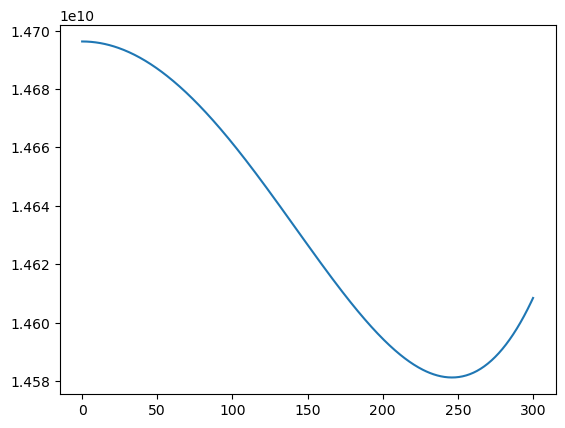

In [18]:
h_list = np.linspace(0,300,500)
y_list = [model.V0([i,0]) for i in h_list]
plt.plot(h_list, y_list)

In [19]:
ScalarMatrix = np.multiply.outer(np.ones((2,2)),0)